## Set up


In [4]:
# Imports

import nltk
nltk.download("punkt")

# !pip install gensim
import gensim

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs
import os

import tensorboard as tb
import tensorflow as tf

import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import random

writer = SummaryWriter('runs/word2vec')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [6]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# mount drive
if not os.path.exists('/content/drive/MyDrive/ICL AI/NLP/NLP_cw'):
    print("making dir")
    os.makedirs('/content/drive/MyDrive/ICL AI/NLP/NLP_cw')

root_path = '/content/drive/MyDrive/ICL AI/NLP/NLP_cw/'

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Hyperparameters and data loading


In [264]:
# Load data for training purposes
# Data is stored locally in my drive at [root]/data/task-1
train_df = pd.read_csv(f'{root_path}train.csv')
dev_df = pd.read_csv(f'{root_path}dev.csv')
test_df = pd.read_csv(f'{root_path}test.csv')

# make sure data is in same folder as root dir!
# train_df = pd.read_csv('train.csv')
# dev_df = pd.read_csv('dev.csv')
# test_df = pd.read_csv('test.csv')

In [265]:
# Number of epochs
epochs = 10

# Proportion of training data for train compared to dev
train_proportion = 0.8

# which batch size?
BATCH_SIZE = 32  # hyperparam

In [266]:
# which model?
# affects:
# - train/evaluation, as BiLSTM has an extra hidden layer initialisation step
# - creation of features, as BiLSTM features are padded within batches and FFN
#   features are padded within the entire dataset

options_models = ["BiLSTM", "BiLSTM-Attention", "FFN"]

model_to_run = 2  # 0 = BiLSTM, 1 = BiLSTM-Attention, 2 = FFN

# which embedding?
# affects:
# - which embeddings file is loaded and used to make word2id, idx2word & wvecs
# - which tokenizer is used, as GloVe doesn't play nice with the ntkl tokenizer

options = [f'{root_path}glove.6B.100d.txt', 'custom_word2vec.txt', "custom_fasttext.txt"]

picked_embeddings = 2  # 0 = pre-made glove, 1 = custom word2vec, 2 = custom fasttext

# file to load the embeddings from
# embedding files should be txt and located in the same working dir as the .ipynb
file_to_load = options[picked_embeddings]  

## Preprocessing


### Making vocabulary


In [267]:
def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list
    punctuation_exclusion = [",", "\'", "\"", ".", "‘", "’"] 

    for sentence in data:

        if picked_embeddings == 0: # glove embeddings

          tokenized_sentence = []
          for token in sentence.split(' '): # simplest split is
            tokenized_sentence.append(token)

            # tokenized_corpus.append(tokenized_sentence)
        else:
          # using nltk tokenizer        
          tokenized_sentence = nltk.tokenize.word_tokenize(sentence.lower())

        cleaned = [token for token in tokenized_sentence if token not in punctuation_exclusion]
        tokenized_corpus.append(cleaned)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

### Padding

In [268]:
def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model
    '''

    batch_labels = [l for f, l in batch]
    batch_features = [f for f, l in batch]

    batch_features_len = [len(f) for f, l in batch]

    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    batch_labels = torch.FloatTensor(batch_labels)

    return seq_tensor, batch_labels

class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

## Model


### BiLSTM

copied from spec

In [269]:
class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 2, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2)

        lstm_out, self.hidden = self.lstm(
            embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)

        out = self.hidden2label(lstm_out[-1])
        return out

### Custom NN

#### BiLSTM Attention

In [270]:
class BiLSTM_ATT(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM_ATT, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 2, 1)
        self.hidden = self.init_hidden()
        
        # Attention layers
        self.attention_linear = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim * 2, bias = True),
            nn.Tanh(),
        )
        self.attention_softmax = nn.Softmax(dim = 0)


    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2)
        lstm_out, self.hidden = self.lstm(
            embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)
        
        # Attention Layers
        att_in = lstm_out
        # Linear operation
        att_linear = self.attention_linear(att_in[-1])
        
        # Apply softmax to get weight of h_ti, t being the num of length of embedded, i being our embedding dim
        att_softmax = self.attention_softmax(att_linear)

        # Extract feature vector
        # Here we extract SUM_(j=1)^t w_i * h_i
        feature_vector = torch.sum(att_softmax * att_in, dim=0)
        # Feature vector now has size batch size * embedding dim

        out = self.hidden2label(feature_vector)
        return out

#### Pytorch dense NN

Also attempted a GRU, but it didn't work, so stuck with feed-forward NN

In [271]:
class FFN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, batch_size, max_feature):
        super(FFN, self).__init__()
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.model = nn.Sequential(
            nn.Linear(embedding_dim*max_feature, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()
        )

    def forward(self, x):
      # input shape: [batch size, sentence length]
      input_len = x.size()[1]

      # print("input size:", x.size()) 
      # print("input: ", x)

      # embedding output shape: [batch size, sentence length, embedding dim]
      embedded = self.embedding(x).view((self.batch_size, -1))

      out = self.model(embedded)
      return out

## Train & eval


In [272]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    
    print("Training model.")
    print(type(model).__name__)

    train_loss = []
    valid_loss_l = []
    train_mse = []
    valid_mse_l = []
    train_rmse = []
    valid_rmse_l = []

    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:

            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]

            # initalise hidden layers for BiLSTM (& BiLSTM w/ attention) only
            if model_to_run == 0 or model_to_run == 1:  
              model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)

            optimizer.zero_grad()

            loss = loss_fn(predictions, target)

            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, __, __ = eval(dev_iter, model)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

        train_loss.append(epoch_loss)
        valid_loss_l.append(valid_loss)
        train_mse.append(epoch_mse)
        valid_mse_l.append(valid_mse)
        train_rmse.append(epoch_mse**.5)
        valid_rmse_l.append(valid_mse**.5)
    return train_loss, train_mse, train_rmse, valid_loss_l, valid_mse_l, valid_rmse_l

In [273]:

# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            if model_to_run == 0 or model_to_run == 1:
              model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [274]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

## Configure data


#### Edit original data

In [275]:
# Edit original sentences
# replace word in original sentence with edit substitution

import re

# train
original_training_data = train_df['original']
train_edit = train_df['edit']
train_edited = [re.sub('<(.+)/>', '<' + edit +'/>', data) for data, edit in zip(original_training_data, train_edit)]

# dev
original_dev_data = dev_df['original']
dev_edit = dev_df['edit']
dev_edited = [re.sub('<(.+)/>', '<' + edit + '/>', data) for data, edit in zip(original_dev_data, dev_edit)]

# test
original_test_data = test_df['original']
test_edit = test_df['edit']
test_edited = [re.sub('<(.+)/>', '<' + edit + '/>', data) for data, edit in zip(original_test_data, test_edit)]


train_df['full_edited'] = train_edited
dev_df['full_edited'] = dev_edited
test_df['full_edit'] = test_edited

#### Setting data, creating vocab

In [276]:
# We set our training data and dev data
training_data = train_df['full_edited']
dev_data = dev_df['full_edited']

# Creating word vectors from train data
training_vocab, training_tokenized_corpus = create_vocab(training_data)

# Creating word vectors from dev data
dev_vocab, dev_tokenized_corpus = create_vocab(dev_data)

# vector for test data
test_vocab, test_tokenized_corpus = create_vocab(test_data)
print("Test vocab created.")

# Creating joint vocab from dev and train:
joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, dev_data]))
print("Train & development vocab created.")

Test vocab created.
Train & development vocab created.


In [277]:
print(joint_tokenized_corpus[:10])

[['france', 'is', 'hunting', 'down', 'its', 'citizens', 'who', 'joined', '<', 'twins/', '>', 'without', 'trial', 'in', 'iraq'], ['pentagon', 'claims', '2,000', '%', 'increase', 'in', 'russian', 'trolls', 'after', '<', 'bowling/', '>', 'strikes', 'what', 'does', 'that', 'mean', '?'], ['iceland', 'pm', 'calls', 'snap', 'vote', 'as', 'pedophile', 'furor', 'crashes', '<', 'party/', '>'], ['in', 'an', 'apparent', 'first', 'iran', 'and', 'israel', '<', 'slap/', '>', 'each', 'other', 'militarily'], ['trump', 'was', 'told', 'weeks', 'ago', 'that', 'flynn', 'misled', '<', 'school/', '>', 'president'], ['all', '22', '<', 'sounds/', '>', 'trump', 'made', 'in', 'his', 'speech', 'to', 'congress', 'in', 'one', 'chart'], ['new', 'doj', 'alert', 'system', 'will', 'flag', '<', 'laughter/', '>', 'against', 'police'], ['as', 'someone', 'who', 'grew', 'up', 'among', 'fundamentalist', '<', 'morons/', '>', 'in', 'the', 'us', 'i', "'m", 'surprised', 'anyone', "'s", 'surprised', 'about', 'roy', 'moore'], ['ca

## Creating embeddings
Pre-trained embeddings (GloVE) should be saved in the same folder as the embeddings created here. This is usually the working directory.

##### word2vec with gensim

In [278]:
if picked_embeddings == 1:
  # word2vec
  model1 = gensim.models.Word2Vec(joint_tokenized_corpus, min_count = 1,  
                                size = 100, window = 5, sg = 1)

  model1.wv.save_word2vec_format("custom_word2vec.txt")
else:
  print(f"picked {options[picked_embeddings]} embeddings, so not creating custom word2vec embeddings")

picked custom_fasttext.txt embeddings, so not creating custom word2vec embeddings


##### fasttext with gensim


In [279]:
# fasttext
# fastText — which is essentially an extension of the word2vec model — 
# treats each *word* as composed of character n-grams. 

if picked_embeddings == 2: # fasttext
  model2 = gensim.models.FastText(joint_tokenized_corpus, min_count = 1,
                                  size=100, window = 5, sg = 1)

  model2.wv.save_word2vec_format("custom_fasttext.txt")
else:
  print(f"picked {options[picked_embeddings]} embeddings, so not creating custom fasttext embeddings")

#### Set embeddings from text

In [280]:
# We create representations for our tokens

# opens correct embeddings file set in previous cell
def create_wvecs(embed_file, vocab, tokenized_corpus):
  """
  Takes in whatever vocab & corpus
  embed_file should be .txt file containing embeddings
  """
  wvecs = [] # word vectors
  word2idx = [] # word2index
  idx2word = []

  # This is a large file, it will take a while to load in the memory!
  with codecs.open(embed_file, 'r','utf-8') as f:
    index = 1
    for line in f.readlines():
      # Ignore the first line - first line typically contains vocab, dimensionality
      if len(line.strip().split()) > 3:
        word = line.strip().split()[0]
        if word in vocab:
            (word, vec) = (word,
                      list(map(float,line.strip().split()[1:])))
            wvecs.append(vec)
            word2idx.append((word, index))
            idx2word.append((index, word))
            index += 1

  wvecs = np.array(wvecs)
  word2idx = dict(word2idx)
  idx2word = dict(idx2word)

  vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in tokenized_corpus]

  # To avoid any sentences being empty (if no words match to our word embeddings)
  vectorized_seqs = [x if len(x) > 0 else [0] for x in vectorized_seqs]

  return wvecs, word2idx, idx2word, vectorized_seqs


## Creating batches and model

#### Splitting dataset & padding

In [281]:
# padd entire dataset to the longest sentence
# used for the FFN
# not necessary for the LSTM

# 'feature' is a list of lists, each containing embedding IDs for word tokens
wvecs, word2idx, idx2word, vectorized_seqs = create_wvecs(file_to_load, 
                                                          joint_vocab, 
                                                          training_tokenized_corpus)


test_wvecs, _, _, vectorized_seqs_test = create_wvecs(file_to_load, 
                                                      test_vocab, 
                                                      test_tokenized_corpus)

# manual padding to longest sentence
def find_max_list(list_in):
    list_len = [len(i) for i in list_in]
    return max(list_len)

def padd_full_data(input_feature, max_len):
  padd_feature = []
  for sentence in input_feature:
    if len(sentence) < max_len:

      diff = max_len - len(sentence)
      new_list = [0]*diff
      sentence.extend(new_list)

      assert len(sentence) == max_len

    padd_feature.append(sentence)

  return padd_feature

if model_to_run == 0 or model_to_run == 1:  # BiLSTM or BiLSTM Attention
  feature = vectorized_seqs
  max_len = 90348 # placeholder 
elif model_to_run == 2:  # FFN, all batches need to have same length

  # check whether theres a sequence in the test set thats longer than in train
  max_len_train = find_max_list(vectorized_seqs)
  max_len_test = find_max_list(vectorized_seqs_test)

  if max_len_train > max_len_test:
    max_len = max_len_train
  else:
    max_len = max_len_test

  # pad training sequences to max length in entire dataset
  feature = padd_full_data(vectorized_seqs, max_len)

  # pad test sequences to max length in entire dataset
  feature_test = padd_full_data(vectorized_seqs_test, max_len)
    

#### Creating model

In [282]:
INPUT_DIM = len(word2idx)  # numbers of tokens
EMBEDDING_DIM = 100  # hyperparam
MAX_LEN = max_len

if model_to_run == 2:  # FFN, max len is length all sentences are padded to
  model = FFN(EMBEDDING_DIM, INPUT_DIM, BATCH_SIZE, MAX_LEN)
elif model_to_run == 0: # BiLSTM, 50 is hidden state size
  model = BiLSTM(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)
elif model_to_run == 1: # BiLSTM Attention, 50 is hidden state size
  model = BiLSTM_ATT(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)

print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

Model initialised.


tensor([[ 0.0189, -0.1200, -0.2173,  ..., -0.1493, -0.2551,  0.1526],
        [-0.1644,  0.0287, -0.1004,  ..., -0.0480, -0.3070,  0.2768],
        [ 0.1596, -0.0489, -0.4639,  ...,  0.2395, -0.6067, -0.1490],
        ...,
        [-0.0996,  0.0444, -0.6507,  ..., -0.0224, -0.6407,  0.3695],
        [-0.1289,  0.0533, -0.5917,  ...,  0.0033, -0.5867,  0.2856],
        [-0.0463,  0.0692, -0.6014,  ..., -0.0291, -0.5963,  0.3522]],
       device='cuda:0')

### Creating train & dev set

In [283]:

train_and_dev = Task1Dataset(feature, train_df['meanGrade'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

Dataloaders created.


## Running model

#### Running model

In [284]:
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())

print(f"running model {options_models[model_to_run]} with embeddings {file_to_load}")

# for making graphs
train_l, train_mse, train_rmse, valid_l, valid_mse, valid_rmse = train(train_loader,dev_loader, model,epochs)

# on BiLSTM w/o padding:
# custom word2vec embed: 
# | Epoch: 10 | Train Loss: 0.13 | Train MSE: 0.13 | Train RMSE: 0.35 | Val. Loss: 0.44 | Val. MSE: 0.44 |  Val. RMSE: 0.66 |

# glove embed:
# | Epoch: 10 | Train Loss: 0.22 | Train MSE: 0.22 | Train RMSE: 0.47 | Val. Loss: 0.38 | Val. MSE: 0.38 |  Val. RMSE: 0.62 |

# custom fasttext embed:
# | Epoch: 10 | Train Loss: 0.12 | Train MSE: 0.12 | Train RMSE: 0.35 | Val. Loss: 0.46 | Val. MSE: 0.46 |  Val. RMSE: 0.67 |


# on FFN w/ padding to len 26:
# custom word2vec: 
# | Epoch: 10 | Train Loss: 0.11 | Train MSE: 0.11 | Train RMSE: 0.33 |         Val. Loss: 0.45 | Val. MSE: 0.45 |  Val. RMSE: 0.67 |

# custom fasttext:
# | Epoch: 10 | Train Loss: 0.11 | Train MSE: 0.11 | Train RMSE: 0.33 |         Val. Loss: 0.43 | Val. MSE: 0.43 |  Val. RMSE: 0.65 |

# pre trained glove:
# | Epoch: 10 | Train Loss: 0.26 | Train MSE: 0.26 | Train RMSE: 0.51 |         Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.61 

running model FFN with embeddings custom_fasttext.txt
Training model.
FFN
| Epoch: 01 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 02 | Train Loss: 0.33 | Train MSE: 0.33 | Train RMSE: 0.58 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 03 | Train Loss: 0.29 | Train MSE: 0.29 | Train RMSE: 0.54 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.59 |
| Epoch: 04 | Train Loss: 0.24 | Train MSE: 0.24 | Train RMSE: 0.49 |         Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 05 | Train Loss: 0.22 | Train MSE: 0.22 | Train RMSE: 0.47 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 06 | Train Loss: 0.21 | Train MSE: 0.21 | Train RMSE: 0.45 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 07 | Train Loss: 0.19 | Train MSE: 0.19 | Train RMSE: 0.44 |         Val. Loss: 0.38 | Val. MSE: 0.38 |  Val. RMSE: 0.62 |
| 

#### Running model on test data

In [285]:
def model_test(data_iter, model):
    """
    Evaluating model performance on the test set
    """
    test_loss, test_mse, _, _ = eval(data_iter, model)

    print(f'| Test Loss: {test_loss:.2f} | Test MSE: {test_mse:.2f} |  Test RMSE: {test_mse**0.5:.2f} |')

test_data = test_df['full_edit']

# test vocab, test_wvecs & vectorized_seqs_test are already initialised above

# We provide the model with our embeddings
if model_to_run == 0 or model_to_run == 1:  # BiLSTM or BiLSTM with attention
  feature_test = vectorized_seqs_test
elif model_to_run == 2: # FFN
  feature_test = feature_test  # already set earlier

test_dataset = Task1Dataset(feature_test, test_df['meanGrade'])

test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

print(f"Testing on {options_models[model_to_run]} with embeddings {file_to_load}")
model_test(test_loader, model)

Dataloaders created.
Testing on FFN with embeddings custom_fasttext.txt
| Test Loss: 0.39 | Test MSE: 0.39 |  Test RMSE: 0.62 |


### Plotting

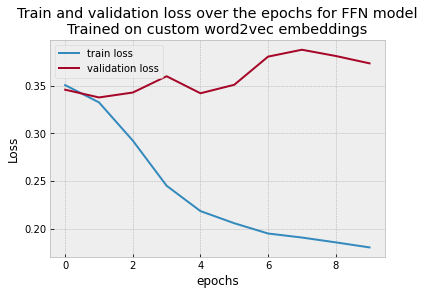

In [286]:
import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.plot(np.arange(0, len(train_l)), train_l, label="train loss")
plt.plot(np.arange(0, len(valid_l)), valid_l, label="validation loss")

# plt.plot(np.arange(0, len(train_rsme)), train_rsme, label="train RMSE")
# plt.plot(np.arange(0, len(valid_rsme)), valid_rsme, label="validation RMSE")
plt.legend(loc="best")

plt.ylabel("Loss")
plt.xlabel("epochs")

plt.title(f"Train and validation loss over the epochs for {options_models[model_to_run]} model\n"
          "Trained on custom word2vec embeddings")

plt.show()
# print(train_losses_D)
# print(train_losses_G)